This is an example for the usage of [Kwasniok/astra-web](https://github.com/Kwasniok/astra-web).

Please read the README.md first to ensure a proper setup of the server.

To become familiar with astra-web it is best to run this notebook on the same machine as the astra-server (`localhost`).
Experienced users may immediately connect to a remote astra-server by changing the `server_url` variable below.


# What you will learn in this example

- configure access to the astra-web server
- download selected simulation data as a feature table
- process the feature table to your liking
- save the feature table for later use

# Preparation

1. start the astra-web server (see README.md)
2. run previous notebook to ensure data exists on the server
3. adjust variables below as you encounter them (e.g. `user_name`, `data_base_name`, `server_url`, `server_port`, etc.)

This example shows a typical workflow for creating a feature table from previously simulated data.
It includes optional sections on processing the features and analyzing the data.

# Import


In [1]:
import os
import json
import logging
from datetime import datetime
import numpy as np
import scipy.constants
import pandas as pd
from astra_web_request import request, RequestMethod
from pmd_beamphysics import ParticleGroup
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

# Config

In [2]:
# Your user name to identify that the data has been created by you.
# You can overwrite this to any name you want if you like. Currently it just tried to get it automatically.
user_name = os.environ.get("USERNAME") or os.environ.get("USER")

# Name of the data set to save files to.
data_base_name = "example"

## Connection to Server

In [3]:
# The name of the machine which is running the astra-web serve.
# Use `localhost` if you are running the server on the same machine as this notebook.
# Otherwise it might look something like `my.server.com` or `192.168.1.1`.
server_hostname = f"localhost"

# Advanced:
# The port on which the astra-web server is running.
# Default is ` 8000` unless you have changed it in the server configuration.
# Tipp: You can have multiple astra-web servers running on the same machine by using different ports.
server_port = 8000

os.environ["ASTRA_WEB_URL"] = f"http://{server_hostname}:{server_port}/"

## Output

In [4]:
out_dir = "data/out"
os.makedirs(out_dir, exist_ok=True)

# Download Results as Feature Table


## Download

### Filter Helper Functions

Advanced: Filter ids for efficiency in case the dataset has multiple experiments. Leave untouched if unsure.

Explanation: If the dataset contains multiple experiments, it is more efficient to filter the simulation ids before downloading the feature table. This avoids unnecessary processing on the server side.

In [5]:
# Regex to filter for specific experiment names.
# Tipp: Use e.g. "experiment v*" to get all experiments starting with "experiment v".
# None means no filtering.
experiment_name_regex = None

In [6]:
def make_filter_by_time(start: datetime = datetime.min, end: datetime = datetime.max):
    """Returns a filter function that filters ids by a time range."""

    def matches(id: str) -> bool:
        id = id[:19]
        dt = datetime.strptime(id, "%Y-%m-%d-%H-%M-%S")
        return start <= dt <= end

    return lambda ids: sorted(list(id for id in ids if matches(id)))

### Check Available Simulations

Note: This operation may take a while depending on the number of simulations stored on the server.

In [7]:
# get all (filtered) simulation ids
sim_ids = await request(f"simulations/ids", RequestMethod.GET)
sim_ids = make_filter_by_time(
    start=datetime.min,
    end=datetime.max,
)(sim_ids)
print(len(sim_ids), "simulations found")

# get states for these simulations
response = await request(
    f"simulations/states",
    RequestMethod.GET,
    body=sim_ids,
    timeout=60 * 60,  # s
)

get_ids_for_state = lambda state: list(id for id, s in response if s == state)
sim_ids = get_ids_for_state("finished")
sim_unfinished_ids = get_ids_for_state("unfinished")
sim_failed_ids = get_ids_for_state("failed")

state_count = lambda state: len(get_ids_for_state(state))

state_count_table = pd.DataFrame(
    dict(
        total=len(response),
        unfinished=state_count("unfinished"),
        finished=state_count("finished"),
        failed=state_count("failed"),
    ),
    index=["simulations"],
)
print(state_count_table)


separator = "\n\t"
if state_count("unfinished") > 0:
    logger.warning(f"{len(sim_unfinished_ids)} simulation(s) are unfinished!")
    logger.warning(f"unfinished:\n\t{separator.join(sim_unfinished_ids)}")

if state_count("failed") > 0:
    logger.warning(f"{len(sim_failed_ids)} simulation(s) have failed!")
    logger.warning(f"failed:\n\t{separator.join(sim_failed_ids)}")

3 simulations found
             total  unfinished  finished  failed
simulations      3           0         3       0


### Download Feature Table

Get a table of all finished simulations including selected features.
Check documentation of astra-web to learn about available features.

NOTE: The server tries to be efficient by only loading the requested features from the simulation files.
E.g. not requesting any data related from the particle distributions can reduce the loading time (ans memory footprint) significantly.
Rule of thumb: The less ASTRA output files need to be looked at, the faster the download will be.

Some features are only available depending on the configuration of ASTRA and/or if the ASTRA generator has been used to create the simulations.

In [8]:
body = {
    "sim_ids": sim_ids,
    "filter_by_comment": experiment_name_regex,
    "features": [
        "sim_id",
        #
        # generator (available only if the ASTRA generator has been used):
        "generator.input.particle_count",
        "generator.output.particles",
        #
        # generator (available only if the raw upload has been used)
        # "generator.meta.comment",
        #
        # simulation input:
        "simulation.input.comment",
        "simulation.input.cavities",
        "simulation.input.solenoids",
        "simulation.input.run.bunch_initial_xy_rms",
        "simulation.input.run.bunch_initial_t_rms",
        "simulation.input.run.thread_num",
        "simulation.input.output.z_stop",
        #
        # simulation output:
        # "simulation.output.norm_emittance_table_x.z",
        # "simulation.output.norm_emittance_table_x.position_mean",
        # "simulation.output.norm_emittance_table_x.position_rms",
        # "simulation.output.norm_emittance_table_x.angle_rms",
        "simulation.output.norm_emittance_table_x.emittance_normalized",
        "simulation.output.norm_emittance_table_x.correlation",
        # "simulation.output.norm_emittance_table_y.z",
        # "simulation.output.norm_emittance_table_y.position_mean",
        # "simulation.output.norm_emittance_table_y.position_rms",
        # "simulation.output.norm_emittance_table_y.angle_rms",
        "simulation.output.norm_emittance_table_y.emittance_normalized",
        "simulation.output.norm_emittance_table_y.correlation",
        # "simulation.output.norm_emittance_table_z.z",
        # "simulation.output.norm_emittance_table_z.E_kin",
        # "simulation.output.norm_emittance_table_z.position_mean",
        # "simulation.output.norm_emittance_table_z.energy_spread_rms",
        "simulation.output.norm_emittance_table_z.emittance_normalized",
        "simulation.output.norm_emittance_table_z.correlation",
        "simulation.output.norm_emittance_table_z.E_kin",
        "simulation.output.norm_emittance_table_z.energy_spread_rms",
        #
        # simulation output particle distributions:
        # WARNING:Reading the full particle distribution for many simulations can take a long time and use a lot of memory!
        "simulation.output.particles",
        "simulation.output.final_particle_counts.total",
        "simulation.output.final_particle_counts.active",
        "simulation.output.final_particle_counts.lost",
        #
        # simulation meta information:
        # WARNING: Loading this meta data takes more time, esp. for large ASTRA .out and .log files
        "simulation.meta.warnings",
        "simulation.meta.execution_time",
        "simulation.meta.cavity_auto_phasing",
    ],
}
response = await request(
    f"features",
    RequestMethod.POST,
    body,
    timeout=100_000,  # s
)

features = pd.DataFrame(response)
del response  # save memory]

In [9]:
if len(features) == 0:
    raise RuntimeError("No data found.")

In [10]:
features.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
generator.input.particle_count,3.0,10000.000000,0.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
simulation.input.run.bunch_initial_xy_rms,3.0,1.000000,0.000000,1.000000,1.00000,1.000000,1.000000,1.000000
simulation.input.run.bunch_initial_t_rms,3.0,0.061896,0.013754,0.046144,0.05708,0.068016,0.069772,0.071527
simulation.input.run.thread_num,3.0,16.000000,0.000000,16.000000,16.00000,16.000000,16.000000,16.000000
simulation.input.output.z_stop,3.0,0.500000,0.000000,0.500000,0.50000,0.500000,0.500000,0.500000
simulation.output.final_particle_counts.total,3.0,10000.000000,0.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
simulation.output.final_particle_counts.active,3.0,9536.333333,576.143501,8891.000000,9305.00000,9719.000000,9859.000000,9999.000000
simulation.output.final_particle_counts.lost,3.0,463.666667,576.143501,1.000000,141.00000,281.000000,695.000000,1109.000000
simulation.meta.execution_time,3.0,70.010000,16.940629,51.380000,62.77000,74.160000,79.325000,84.490000


# Optional: Post Processing

Sometimes the data need to be processed further.
Some examples are shown here.
Adjust this to your personal needs.

In [11]:
def process_emittances(features):

    def select_final(orig, new):
        features[new] = features[orig].apply(
            lambda x: x[-1] if isinstance(x, list) else np.nan
        )

    select_final(
        "simulation.output.norm_emittance_table_x.emittance_normalized",
        "final_emittance_x",
    )
    select_final(
        "simulation.output.norm_emittance_table_y.emittance_normalized",
        "final_emittance_y",
    )
    select_final(
        "simulation.output.norm_emittance_table_z.emittance_normalized",
        "final_emittance_z",
    )
    select_final(
        "simulation.output.norm_emittance_table_x.correlation",
        "final_emittance_correlation_x",
    )
    select_final(
        "simulation.output.norm_emittance_table_y.correlation",
        "final_emittance_correlation_y",
    )
    select_final(
        "simulation.output.norm_emittance_table_z.correlation",
        "final_emittance_correlation_z",
    )
    select_final("simulation.output.norm_emittance_table_z.E_kin", "final_E_kin")
    select_final(
        "simulation.output.norm_emittance_table_z.energy_spread_rms",
        "final_energy_spread_rms",
    )

    features["final_emittance_xy"] = (
        features["final_emittance_x"] * features["final_emittance_y"]
    ) ** 0.5


process_emittances(features)

In [12]:
def process_modules(features):
    def select_module_property(features, type, comment, property, new):
        features[new] = features[f"simulation.input.{type}"].apply(
            lambda cavs: next(
                (cav[property] for cav in cavs if cav["comment"] == comment), np.nan
            )
        )

    select_module_property(features, "cavities", "gun", "Phi", "gun_phase")
    select_module_property(features, "cavities", "gun", "MaxE", "gun_E_max")
    select_module_property(
        features, "solenoids", "focussing solenoid", "MaxB", "sol_B_max"
    )


process_modules(features)

In [13]:
def convert_particle_distributions_to_data_frame(features: pd.DataFrame) -> None:
    """Resolves particle distributions to SI units."""

    def transform(dist):
        return pd.DataFrame(dist)

    def list_transform(dists):
        return list(map(pd.DataFrame, dists))

    def action(fs, key, is_list: bool = False):
        fs[key] = fs[key].apply(list_transform if is_list else transform)

    if "generator.output.particles" in features:
        action(features, "generator.output.particles")

    if "simulation.output.particles" in features:
        action(features, "simulation.output.particles", is_list=True)


convert_particle_distributions_to_data_frame(features)

openpmd used different units than ASTRA

In [14]:
def make_resolve_units(table: pd.DataFrame) -> pd.DataFrame:
    """
    Resolves units to be openpmd compatible.
    """
    # e_volts_per_c = scipy.constants.e / scipy.constants.c
    table["t_clock"] = table["t_clock"] * 1e-9  # ns -> s
    table["macro_charge"] = table["macro_charge"] * 1e-9  # nC -> C
    # table["px"] = table["px"] * e_volts_per_c # eV/c -> Js/m
    # table["py"] = table["py"] * e_volts_per_c # eV/c -> Js/m
    # table["pz"] = table["pz"] * e_volts_per_c # eV/c -> Js/m
    return table

In [15]:
def rescale_particle_distributions_units(features: pd.DataFrame) -> None:
    """Resolves particle distributions to SI units."""

    def transform(dist):
        return make_resolve_units(dist)

    def list_transform(dists):
        return list(map(make_resolve_units, dists))

    def action(fs, key, is_list: bool = False):
        fs[key] = fs[key].apply(list_transform if is_list else transform)

    if "generator.output.particles" in features:
        action(features, "generator.output.particles")

    if "simulation.output.particles" in features:
        action(features, "simulation.output.particles", is_list=True)


rescale_particle_distributions_units(features)

Each ASTRA simulation can rescale the initial particle distribution.
Apply this scaling to the data from the generator if available.

In [16]:
def _numerical_rms(x, y) -> float:
    """
    RMS width of a probability distribution.
    x : domain values
    y : probability density (doesn't need to be normalized)
    """
    y = np.array(y)
    x = np.array(x)

    norm = np.trapezoid(y, x)  # integral over domain
    if norm == 0:
        return np.nan

    mean = np.trapezoid(x * y, x) / norm
    variance = np.trapezoid((x - mean) ** 2 * y, x) / norm
    return np.sqrt(variance).item()

In [17]:
def numerical_rms(values, bins: int = 1000) -> float:
    """
    RMS width of a probability distribution represented by a list of sampled values.
    values : values sampled by the distribution
    """
    y, x = np.histogram(values, bins=bins)
    x = 0.5 * (x[1:] + x[:-1])
    return _numerical_rms(x, y)

In [18]:
def rescale_initial_particle_distribution_by_t_rms(features: pd.DataFrame) -> None:

    def action(fs, key):
        t = fs[key]["t_clock"]
        original_t_rms = numerical_rms(t)
        t = (
            t
            * fs["simulation.input.run.bunch_initial_t_rms"]
            * 1e-9  ## ns -> s
            / original_t_rms
        )
        fs[key]["t_clock"] = t

    if "generator.output.particles" in features:
        action(features, "generator.output.particles")

In [19]:
def rescale_initial_particle_distribution_by_xy_rms(features: pd.DataFrame) -> None:

    def action(fs, key, is_list: bool = False):
        x = fs[key]["x"]
        y = fs[key]["y"]
        original_x_rms = numerical_rms(x)
        original_y_rms = numerical_rms(y)
        x = (
            x
            * fs["simulation.input.run.bunch_initial_xy_rms"]
            * 1e-3  # mm -> m
            / original_x_rms
        )
        y = (
            y
            * fs["simulation.input.run.bunch_initial_xy_rms"]
            * 1e-3  # mm -> m
            / original_y_rms
        )
        fs[key]["x"] = x
        fs[key]["y"] = y

    if "generator.output.particles" in features:
        action(features, "generator.output.particles")

In [20]:
def rescale_initial_particle_distribution(features: pd.DataFrame) -> None:
    def transform(fs):
        rescale_initial_particle_distribution_by_t_rms(fs)
        rescale_initial_particle_distribution_by_xy_rms(fs)

    features = features.apply(transform, axis=1)


rescale_initial_particle_distribution(features)

ASTRA has the convention to use the first row of the particle distribution as reference particle.
All other rows are relative to this reference particle.
Resolve this to absolute values.

In [21]:
def make_resolve_relative(table: pd.DataFrame, columns: list[str]) -> pd.DataFrame:
    """
    First row is reference. Subsequent rows have columns which are given as relative to the reference (addition).

    Returns table with values in absolute reference frame.
    """
    for col in columns:
        if col in table.columns:
            ref = table.iloc[0]
            table.loc[1:, col] = table.loc[1:, col].add(ref[col])
    return table

In [22]:
def resolve_particle_distributions(features: pd.DataFrame) -> None:
    """Resolves particle distributions to absolute reference frame and SI units."""

    def transform(dist):
        return make_resolve_relative(dist, ["z", "pz", "t_clock"])

    def list_transform(dists):
        return list(make_resolve_relative(d, ["z", "pz", "t_clock"]) for d in dists)

    def action(fs, key, is_list: bool = False):
        fs[key] = fs[key].apply(list_transform if is_list else transform)

    if "generator.output.particles" in features:
        action(features, "generator.output.particles")

    if "simulation.output.particles" in features:
        action(features, "simulation.output.particles", is_list=True)


resolve_particle_distributions(features)

Convert a particle distribution to openpmd particle group.

In [23]:
def to_particle_group(dist):
    data = dict(
        x=dist["x"],
        px=dist["px"],
        y=dist["y"],
        py=dist["py"],
        z=dist["z"],
        pz=dist["pz"],
        t=dist["t_clock"]
        * np.nan,  # NOTE: For z!=0 and non-refernce particle t is more complicated
        species="electron",
        status=list(s >= 0 for s in dist["status_flag"]),
        weight=1.0,
    )
    pg = ParticleGroup(data=data)
    pg.charge = -dist["macro_charge"].sum().item()
    return pg

Use openpmd tools to derive more features from the particle distribution.

In [24]:
def process_final_peak_density(features):

    if "simulation.output.particles" in features:

        def action(dists):
            dist = dists[-1]
            pg = to_particle_group(dist)
            slices = pg.slice_statistics("twiss")
            return slices["density"].max()

        features["final_peak_density"] = features["simulation.output.particles"].apply(
            action
        )


process_final_peak_density(features)

/data/dust/user/kwasniok/astra/astra-web-kwasniok/example/.venv/lib/python3.13/site-packages/pmd_beamphysics/particles.py:1157: RuntimeWarning: divide by zero encountered in divide
  slice_dat[density_name] = slice_dat["charge"] / slice_dat["ptp_" + slice_key]


In [25]:
def process_final_twiss_params(features):

    if "simulation.output.particles" in features:

        def action(dists):
            dist = dists[-1]
            pg = to_particle_group(dist)
            twiss_x = pg.twiss("x")
            twiss_y = pg.twiss("y")
            return (
                twiss_x["alpha_x"],
                twiss_x["beta_x"],
                twiss_x["gamma_x"],
                twiss_y["alpha_y"],
                twiss_y["beta_y"],
                twiss_y["gamma_y"],
            )

        features[
            [
                "final_twiss_x_alpha",
                "final_twiss_x_beta",
                "final_twiss_x_gamma",
                "final_twiss_y_alpha",
                "final_twiss_y_beta",
                "final_twiss_y_gamma",
            ]
        ] = pd.DataFrame(
            features["simulation.output.particles"].apply(action).to_list()
        )


process_final_twiss_params(features)

In [26]:
def process_final_bunch_length(features):

    if "simulation.output.particles" in features:

        def action(dists):
            dist = dists[-1]
            pg = to_particle_group(dist)
            return pg.z.std()

        features["final_bunch_length"] = features["simulation.output.particles"].apply(
            action
        )


process_final_bunch_length(features)

## Cut Outliers


In [27]:
def remove_outliers(df, column, min_value=None, max_value=None):
    """Drops rows where column is outside [min_value, max_value]."""
    if column not in df.columns:
        return df

    if min_value is not None:
        df = df[df[column] >= min_value]
    if max_value is not None:
        df = df[df[column] <= max_value]
    return df


# features = remove_outliers(features, "final_emittance_xy", max_value=1e3)  # pi mm mrad
# features = remove_outliers(features, "final_emittance_z", max_value=1e4)  # pi keV mm

Show overview of the processed feature table.

In [28]:
print(len(features))
display(features[:1])
display(features.describe().transpose())

3


,sim_id,generator.input.particle_count,generator.output.particles,simulation.input.comment,simulation.input.cavities,simulation.input.solenoids,simulation.input.run.bunch_initial_xy_rms,simulation.input.run.bunch_initial_t_rms,simulation.input.run.thread_num,simulation.input.output.z_stop,...,gun_E_max,sol_B_max,final_peak_density,final_twiss_x_alpha,final_twiss_x_beta,final_twiss_x_gamma,final_twiss_y_alpha,final_twiss_y_beta,final_twiss_y_gamma,final_bunch_length
0,2026-02-03-15-39-45-X7fkjTGa,10000,x y z px ...,example v1,"[{'comment': 'gun', 'File_Efield': 'C1_E.dat',...","[{'comment': 'focussing solenoid', 'File_Bfiel...",1.0,0.071527,16,0.5,...,60.0,0.21,inf,0.781595,0.436863,3.687404,0.765951,0.432286,3.670445,0.157795


/data/dust/user/kwasniok/astra/astra-web-kwasniok/example/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:4597: RuntimeWarning: invalid value encountered in multiply
  lerp_interpolation = add(a, diff_b_a * t, out=... if out is None else out)
/data/dust/user/kwasniok/astra/astra-web-kwasniok/example/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:4598: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,
/data/dust/user/kwasniok/astra/astra-web-kwasniok/example/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1020: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,count,mean,std,min,25%,50%,75%,max
generator.input.particle_count,3.0,1.000000e+04,0.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,1.000000e+04
simulation.input.run.bunch_initial_xy_rms,3.0,1.000000e+00,0.000000,1.000000e+00,1.000000,1.000000,1.000000,1.000000e+00
simulation.input.run.bunch_initial_t_rms,3.0,6.189572e-02,0.013754,4.614414e-02,0.057080,0.068016,0.069772,7.152689e-02
simulation.input.run.thread_num,3.0,1.600000e+01,0.000000,1.600000e+01,16.000000,16.000000,16.000000,1.600000e+01
simulation.input.output.z_stop,3.0,5.000000e-01,0.000000,5.000000e-01,0.500000,0.500000,0.500000,5.000000e-01
simulation.output.final_particle_counts.total,3.0,1.000000e+04,0.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,1.000000e+04
simulation.output.final_particle_counts.active,3.0,9.536333e+03,576.143501,8.891000e+03,9305.000000,9719.000000,9859.000000,9.999000e+03
simulation.output.final_particle_counts.lost,3.0,4.636667e+02,576.143501,1.000000e+00,141.000000,281.000000,695.000000,1.109000e+03
simulation.meta.execution_time,3.0,7.001000e+01,16.940629,5.138000e+01,62.770000,74.160000,79.325000,8.449000e+01
final_emittance_x,3.0,3.009400e+01,16.093164,1.233500e+01,23.285000,34.235000,38.973500,4.371200e+01


# Save

Tipp: Partricle distributions can be large. Consider not saving them if possible.

In [29]:
def save_feature_table(
    features: pd.DataFrame, path: str, *, skip_particle_distributions: bool = False
) -> None:
    """Saves the feature table and its meta data to a file."""

    if skip_particle_distributions:
        features = features.drop(
            columns=[
                "generator.output.particles",
                "simulation.output.particles",
            ],
            errors="ignore",
        )

    metadata = {
        "author": user_name,
        "date": datetime.now().isoformat(),
        "columns": features.columns.tolist(),
        "dtypes": features.dtypes.astype(str).to_dict(),
    }

    os.makedirs(os.path.dirname(path), exist_ok=True)

    np.savez(
        path,
        features=features,
        metadata=json.dumps(metadata),
    )


save_feature_table(
    features, path=f"{out_dir}/feature_tables/" + data_base_name + ".npz"
)

# Optional: Inspect Feature Table
Some examples on how to inspect the feature table.

Here, the simulation with the lowest projected normalized transversal emittance is highlighted.

In [30]:
if "simulation.meta.execution_time" in features.columns:
    px.histogram(
        features,
        x="simulation.meta.execution_time",
        title="Simulation Execution Time",
        labels={"simulation.meta.execution_time": "Execution Time [s]"},
    ).show()

In [31]:
px.imshow(
    features.select_dtypes("number").corr(),
    color_continuous_scale="RdBu",
    color_continuous_midpoint=0,
    title="feature correlation matrix",
    width=800,
    height=800,
).show()

## Select Simulations of Interest

Here, the lowest projected normalized transversal emittance is selected.

In [32]:
selected_sims = features.nsmallest(2, "final_emittance_xy")
selected_sims.iloc[0]

sim_id                                                                                2026-02-03-15-42-32-Q2Cyzt74
generator.input.particle_count                                                                               10000
generator.output.particles                                                    x         y    z          px     ...
simulation.input.comment                                                                                example v1
simulation.input.cavities                                        [{'comment': 'gun', 'File_Efield': 'C1_E.dat',...
simulation.input.solenoids                                       [{'comment': 'focussing solenoid', 'File_Bfiel...
simulation.input.run.bunch_initial_xy_rms                                                                      1.0
simulation.input.run.bunch_initial_t_rms                                                                  0.046144
simulation.input.run.thread_num                                                 

## Visualize Selected Simulation

In [33]:
# data for plot beautification & debugging

pgs = list(map(to_particle_group, selected_sims.iloc[0]["simulation.output.particles"]))
pg = pgs[-1]
pg_slices = pd.DataFrame(
    pg.slice_statistics(
        "mean_z",
        "norm_emit_x",
        "norm_emit_y",
        "sigma_x",
        "sigma_y",
        "sigma_px",
        "sigma_py",
        "sigma_pz",
        "mean_energy",
        "twiss",
        n_slice=200,
        slice_key="z",
    )
)
print(pg_slices.keys())

Index(['sigma_pz', 'charge', 'ptp_z', 'sigma_py', 'twiss', 'norm_emit_y',
       'norm_emit_x', 'mean_energy', 'sigma_px', 'sigma_y', 'mean_z',
       'sigma_x', 'twiss_alpha_x', 'twiss_beta_x', 'twiss_gamma_x',
       'twiss_emit_x', 'twiss_eta_x', 'twiss_etap_x', 'twiss_norm_emit_x',
       'twiss_alpha_y', 'twiss_beta_y', 'twiss_gamma_y', 'twiss_emit_y',
       'twiss_eta_y', 'twiss_etap_y', 'twiss_norm_emit_y', 'density'],
      dtype='str')


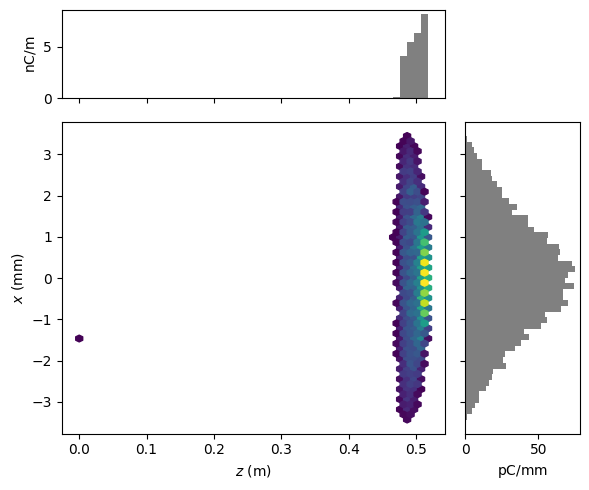

In [34]:
def make_plot_zx(pg: ParticleGroup) -> plt.Figure:
    fig: plt.Figure = pg.plot("z", "x", figsize=(6, 5), return_figure=True)
    fig.tight_layout()
    return fig


make_plot_zx(pg).show()

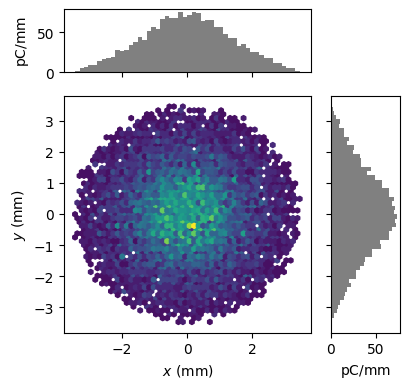

In [35]:
def make_plot_xy(pg: ParticleGroup) -> plt.Figure:
    fig: plt.Figure = pg.plot("x", "y", figsize=(4.2, 4), return_figure=True)
    fig.tight_layout()
    return fig


make_plot_xy(pg).show()

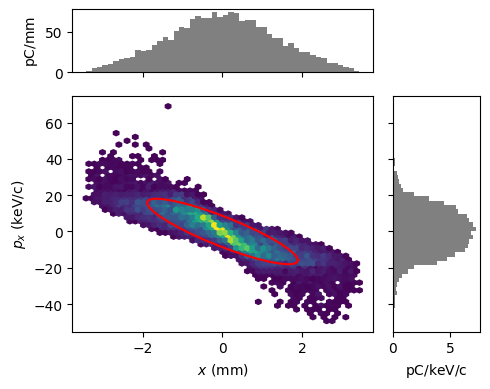

In [36]:
def make_plot_x_px(pg: ParticleGroup) -> plt.Figure:
    fig: plt.Figure = pg.plot(
        "x", "px", figsize=(5, 4), return_figure=True, ellipse=True
    )
    fig.tight_layout()
    return fig


make_plot_x_px(pg).show()

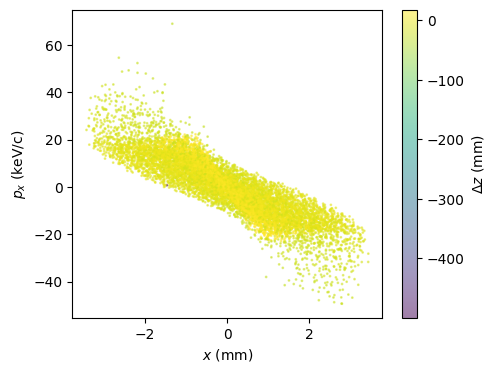

In [48]:
def make_plot_x_px_colored_by_z(pg: ParticleGroup) -> plt.Figure:
    x = pg["x"] * 1e3
    px = pg["px"] * 1e-3
    z = pg["z"] * 1e3
    z -= z.mean()
    fig = plt.figure(figsize=(5, 4))
    ax = fig.add_subplot()
    sc = ax.scatter(x, px, c=z, s=1, alpha=0.5)  # , cmap="RdBu")
    ax.set_xlabel("$x$ (mm)")
    ax.set_ylabel("$p_x$ (keV/c)")
    fig.colorbar(sc, ax=ax, label=r"$\Delta z$ (mm)")
    return fig


make_plot_x_px_colored_by_z(pg).show()

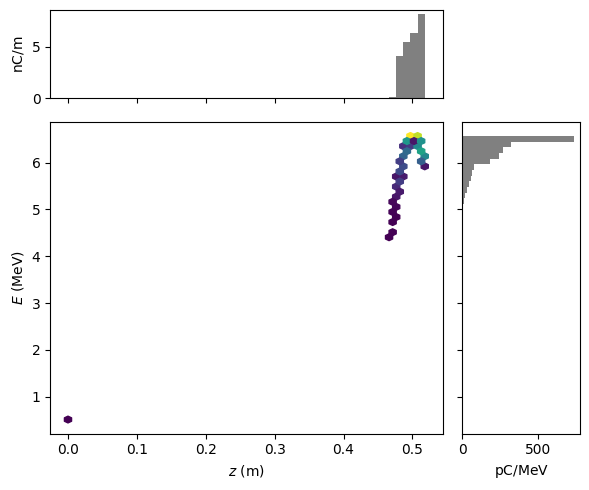

In [38]:
def make_plot_z_energy(pg: ParticleGroup) -> plt.Figure:
    fig: plt.Figure = pg.plot("z", "energy", figsize=(6, 5), return_figure=True)  # type: ignore
    fig.tight_layout()
    return fig


make_plot_z_energy(pg).show()

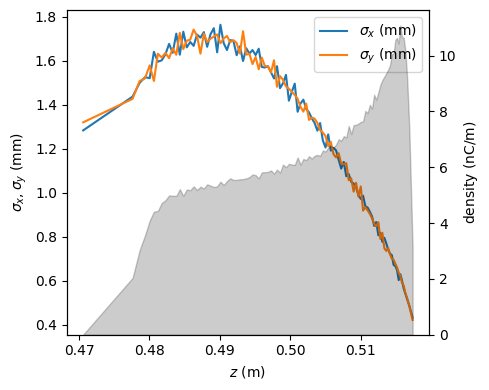

In [39]:
def make_plot_slice_sigma_xy(pg: ParticleGroup) -> plt.Figure:
    fig: plt.Figure = pg.slice_plot(
        "sigma_x", "sigma_y", figsize=(5, 4), return_figure=True
    )
    fig.tight_layout()
    return fig


make_plot_slice_sigma_xy(pg).show()

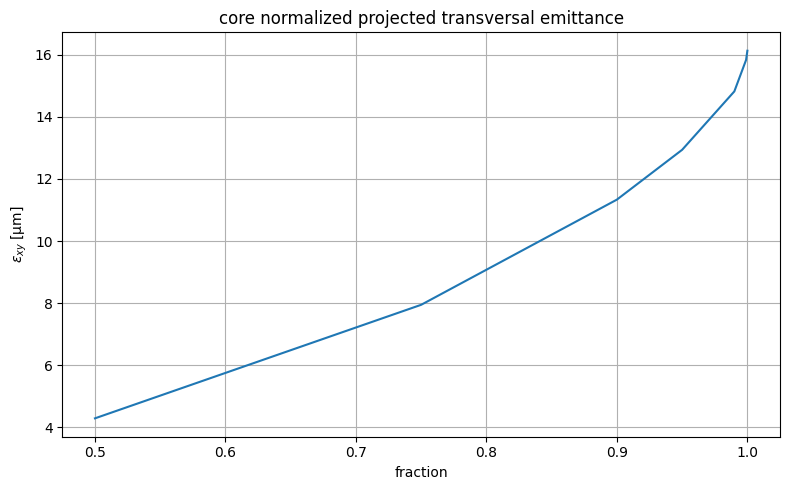

In [40]:
def make_plot_core_emit_xy(
    pg: ParticleGroup,
    fracs: list[float] = [0.5, 0.75, 0.9, 0.95, 0.99, 0.999, 1.0],
) -> plt.Figure:

    twiss_core = (
        pd.DataFrame({f: pd.Series(pg.twiss("xy", fraction=f)) for f in fracs})
        .transpose()
        .reset_index()
        .rename(columns={"index": "fraction"})
    )

    fig, ax = plt.subplots(figsize=(8, 5))
    ax.plot(
        twiss_core["fraction"],
        np.sqrt(twiss_core["norm_emit_x"] * twiss_core["norm_emit_y"]) * 1e6,
        label=r"$\varepsilon_{xy}$",
    )
    ax.set_title("core normalized projected transversal emittance")
    ax.set_xlabel("fraction")
    ax.set_ylabel(r"$\varepsilon_{xy}$ [µm]")
    # ax.legend()
    ax.grid(True)
    fig.tight_layout()

    return fig


make_plot_core_emit_xy(pg).show()

In [41]:
def thermal_emittance(pg: ParticleGroup) -> float:
    c = scipy.constants.speed_of_light
    e = scipy.constants.e
    m0 = scipy.constants.electron_mass
    # NOTE: px is in eV/c! Hence the additional factor of e/c
    return pg["sigma_x"] * pg["sigma_px"] * e / (m0 * c**2)


thermal_emittance(pgs[0]), pgs[0]["norm_emit_x"]

(np.float64(2.8510406838545115e-05), np.float64(5.1634752054758304e-06))

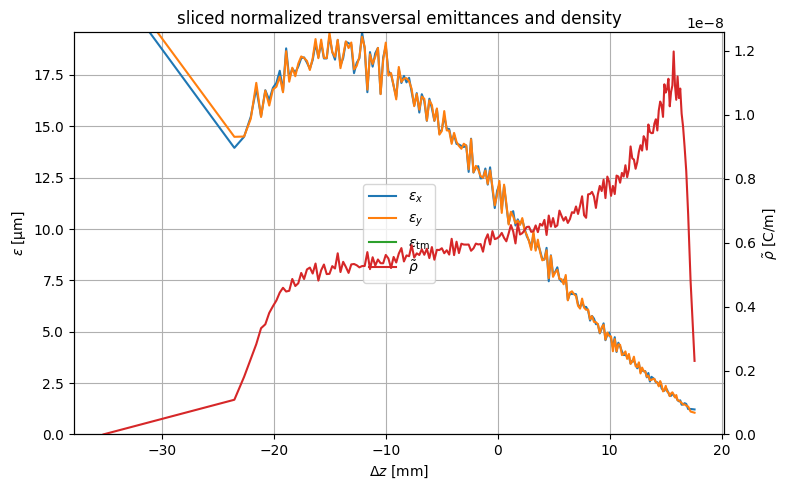

In [42]:
def make_plot_slice_emittance_and_density(
    pg_slices: pd.DataFrame,
    *,
    emittance_xy_thermal: float | None = None,
    z_rel_cutoff: float | None = None,
) -> plt.Figure:
    """
    Creates figure plotting sliced normalized transversal emittances xy and density.

    Args:
        emittance_xy_thermal: Show horizontal line for thermal emittance.
        z_rel_cutoff: Ignore emittance values outside of this fraction offcenter for scaling the y-axis. Usefull when emittance explodes for large |z - z_0|.
    """
    z_mm = (pg_slices["mean_z"] - pg_slices["mean_z"].mean()) * 1e3
    e_x = pg_slices["norm_emit_x"] * 1e6
    e_y = pg_slices["norm_emit_y"] * 1e6

    fig, ax1 = plt.subplots(figsize=(8, 5))
    # emittances
    ax1.plot(
        z_mm,
        e_x,
        label=r"$\varepsilon_x$",
    )
    ax1.plot(
        z_mm,
        e_y,
        label=r"$\varepsilon_y$",
    )
    # thermal emittance
    if emittance_xy_thermal:
        ax1.plot(
            [z_mm.min(), z_mm.max()],
            np.array([emittance_xy_thermal, emittance_xy_thermal]) * 1e6,
            label=r"$\varepsilon_{\text{tm}}$",
        )
    # z cutoff
    if z_rel_cutoff:
        lx = z_rel_cutoff * z_mm.max().item()
        # ax1.set_xlim([-lx, lx])
        mask = (z_mm > -lx) & (z_mm < lx)
        ly = max(e_x[mask].max(), e_y[mask].max())
        ax1.set_ylim([0, ly])
    # general
    ax1.set_xlabel(r"$\Delta z$ [mm]")
    ax1.set_ylabel(r"$\varepsilon$ [µm]")
    ax1.grid(True)
    # current
    ax2 = ax1.twinx()
    ax2.plot(
        z_mm,
        pg_slices["density"],
        color="tab:red",
        label=r"$\tilde{\rho}$",
    )
    # general
    ax2.set_ylim([0, None])
    ax2.set_ylabel(r"$\tilde{\rho}$ [C/m]")
    # combined legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc="center")
    # general
    ax1.set_title("sliced normalized transversal emittances and density")
    fig.tight_layout()
    return fig


make_plot_slice_emittance_and_density(
    pg_slices,
    emittance_xy_thermal=thermal_emittance(pgs[0]),
    z_rel_cutoff=0.9,
).show()

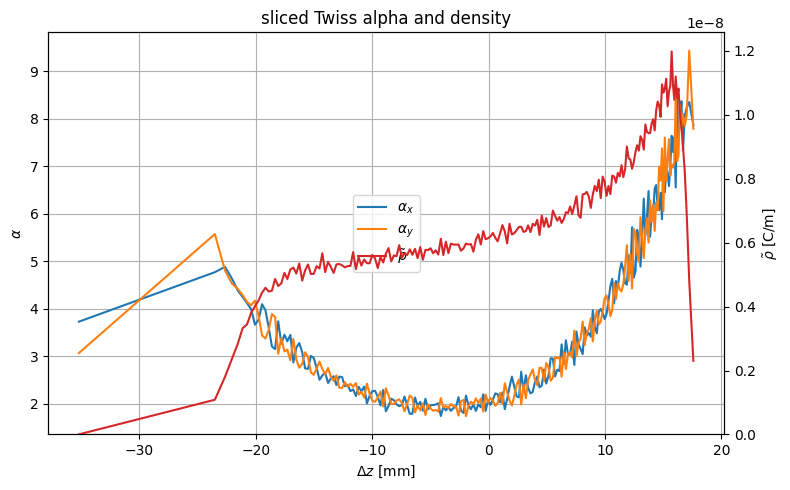

In [43]:
def make_plot_slice_twiss_alpha_and_density(
    pg_slices: pd.DataFrame,
) -> plt.Figure:

    z_mm = (pg_slices["mean_z"] - pg_slices["mean_z"].mean()) * 1e3
    twiss_alpha_x = pg_slices["twiss_alpha_x"]
    twiss_alpha_y = pg_slices["twiss_alpha_y"]

    fig, ax1 = plt.subplots(figsize=(8, 5))
    # emittances
    ax1.plot(
        z_mm,
        twiss_alpha_x,
        label=r"$\alpha_x$",
    )
    ax1.plot(
        z_mm,
        twiss_alpha_y,
        label=r"$\alpha_y$",
    )
    # general
    ax1.set_xlabel(r"$\Delta z$ [mm]")
    ax1.set_ylabel(r"$\alpha$")
    ax1.grid(True)
    # current
    ax2 = ax1.twinx()
    ax2.plot(
        z_mm,
        pg_slices["density"],
        color="tab:red",
        label=r"$\tilde{\rho}$",
    )
    # general
    ax2.set_ylim([0, None])
    ax2.set_ylabel(r"$\tilde{\rho}$ [C/m]")
    # combined legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc="center")
    # general
    ax1.set_title("sliced Twiss alpha and density")
    fig.tight_layout()
    return fig


make_plot_slice_twiss_alpha_and_density(pg_slices).show()

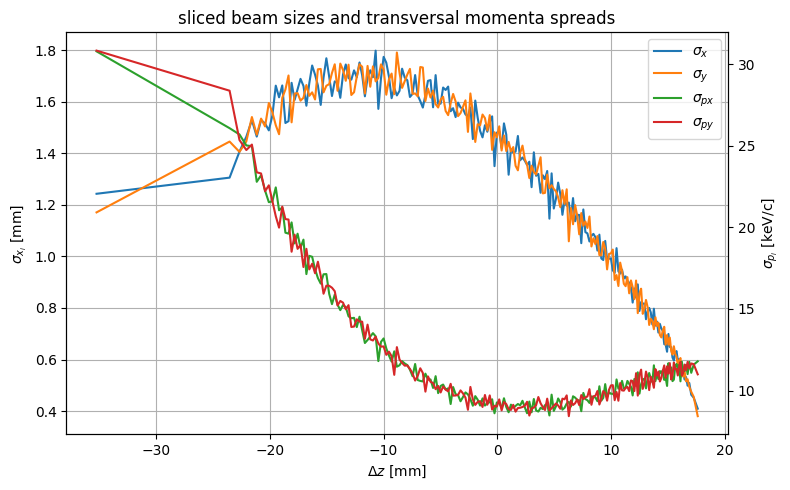

In [44]:
def make_plot_slice_beamsizes_and_momenta_spreads(
    pg_slices: pd.DataFrame,
) -> plt.Figure:

    z_mm = (pg_slices["mean_z"] - pg_slices["mean_z"].mean()) * 1e3

    fig, ax1 = plt.subplots(figsize=(8, 5))
    # beam sizes
    ax1.plot(
        z_mm,
        pg_slices["sigma_x"] * 1e3,
        label=r"$\sigma_x$",
    )
    ax1.plot(
        z_mm,
        pg_slices["sigma_y"] * 1e3,
        label=r"$\sigma_y$",
    )
    ax1.set_xlabel(r"$\Delta z$ [mm]")
    ax1.set_ylabel(r"$\sigma_{x_i}$ [mm]")
    ax1.grid(True)
    # momenta spreads
    ax2 = ax1.twinx()
    ax2.plot(
        z_mm,
        pg_slices["sigma_px"] * 1e-3,
        color="tab:green",
        label=r"$\sigma_{px}$",
    )
    ax2.plot(
        z_mm,
        pg_slices["sigma_py"] * 1e-3,
        color="tab:red",
        label=r"$\sigma_{py}$",
    )
    ax2.set_ylabel(r"$\sigma_{p_i}$ [keV/c]")
    # combined legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc="best")
    # general
    ax1.set_title("sliced beam sizes and transversal momenta spreads")
    fig.tight_layout()
    return fig


make_plot_slice_beamsizes_and_momenta_spreads(pg_slices).show()

In [45]:
def save_particle_distribution_plots(
    features: pd.Series,
    out_dir: str,
    *,
    z_index: int = -1,
    n_slice: int = 200,
) -> None:
    """
    Saves various plots of the particle distribution.

    Args:
        features: DataFrame containing the features including particle distributions.
        out_dir: Output directory to save the plots.
        z_index: Index of the z position to select the particle distribution from. Default is -1 (final position).
        n_slice: Number of slices for slice statistics.
        slice_key: Key to use for slicing (e.g., 't' for time).
    """

    # convert to ParticleGroup
    pgs = (
        [to_particle_group(features["generator.output.particles"])]
        if "generator.output.particles" in features
        else []
    )
    pgs += (
        list(map(to_particle_group, features["simulation.output.particles"]))
        if "simulation.output.particles" in features
        else []
    )

    if pgs:
        pg = pgs[-1]

        # slice
        pg_slices = pd.DataFrame(
            pg.slice_statistics(
                "mean_z",
                "norm_emit_x",
                "norm_emit_y",
                "sigma_x",
                "sigma_y",
                "sigma_px",
                "sigma_py",
                "sigma_pz",
                "mean_energy",
                "twiss",
                n_slice=n_slice,
                slice_key="z",
            )
        )

        # output dir
        z_name = f"{pg['mean_z']:0.3f}"
        out_dir = os.path.join(out_dir, "particle_distribution", z_name)
        os.makedirs(out_dir, exist_ok=True)

        # save plots

        # beam size
        fig = make_plot_zx(pg)
        fig.savefig(f"{out_dir}/zx.png")
        plt.close(fig)

        fig = make_plot_xy(pg)
        fig.savefig(f"{out_dir}/xy.png")
        plt.close(fig)

        # phase space
        fig = make_plot_x_px(pg)
        fig.savefig(f"{out_dir}/x_px.png")
        plt.close(fig)

        fig = make_plot_x_px_colored_by_z(pg)
        fig.savefig(f"{out_dir}/x_px_colored_by_z.png")
        plt.close(fig)

        fig = make_plot_z_energy(pg)
        fig.savefig(f"{out_dir}/z_energy.png")
        plt.close(fig)

        # core emittance
        fig = make_plot_core_emit_xy(pg)
        fig.savefig(f"{out_dir}/core_emit_xy.png")
        plt.close(fig)

        # sliced statistics
        fig = make_plot_slice_emittance_and_density(
            pg_slices,
            emittance_xy_thermal=thermal_emittance(pgs[0]),
        )
        fig.savefig(f"{out_dir}/slice_emittance_and_density.png")
        plt.close(fig)

        fig = make_plot_slice_emittance_and_density(
            pg_slices,
            emittance_xy_thermal=thermal_emittance(pgs[0]),
            z_rel_cutoff=0.9,
        )
        fig.savefig(f"{out_dir}/slice_emittance_and_density_with_cutoff.png")
        plt.close(fig)

        fig = make_plot_slice_twiss_alpha_and_density(pg_slices)
        fig.savefig(f"{out_dir}/slice_twiss_alpha_and_density.png")
        plt.close(fig)

        fig = make_plot_slice_beamsizes_and_momenta_spreads(pg_slices)
        fig.savefig(f"{out_dir}/slice_beamsizes_and_momenta_spreads.png")
        plt.close(fig)

In [46]:
def save_visualizations_for_sim(features):
    """Saves visualizations."""
    o_dir = f"{out_dir}/sim/{features['sim_id']}"

    save_particle_distribution_plots(features, o_dir)

## Save Plots


In [47]:
save_visualizations_for_sim(selected_sims.iloc[0])